In [5]:
from sklearn.datasets import fetch_openml
import numpy as np

In [6]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

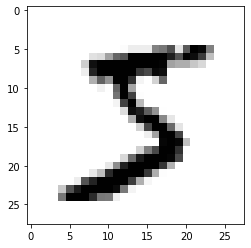

In [22]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest") 
plt.axis("on")
plt.show()

In [23]:
y[0]

5

In [24]:
y = y.astype(np.uint8)

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [30]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

In [34]:
#np.unique(y)
print(y_train[:10])
y_train_5[:10]

[5 0 4 1 9 2 1 3 1 4]


array([ True, False, False, False, False, False, False, False, False,
       False])

In [35]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5) # just train for value 5, single class classifier

SGDClassifier(random_state=42)

In [36]:
sgd_clf.predict([some_digit])
# it did predicted 5 true

array([ True])

In [12]:
#alternate way 
# but let try the cross_val_score to test our mode next step
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index] 
    y_train_folds = y_train_5[train_index] 
    X_test_fold = X_train[test_index] 
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold) 
    print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.95035
0.96035
0.9604


In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") 
# shows good accuracy but not in reality.
# This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e.,# when some classes are much more frequent than others

array([0.95035, 0.96035, 0.9604 ])

In [39]:
# We could make predictions on the test set, but let’s keep it untouched for now (remember use the test set only at the very end of your # project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

#Just like the cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
#check confusion matrix for TP, TN, FP, FN

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)
print(precision)
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.8370879772350012


0.6511713705958311

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
#The F1 score favors classifiers that have similar precision and recall. In some contexts you mostly care about precision, and in other contexts you really care about recall.

0.7325171197343846

In [41]:
#Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. 

#some_digit[0:10]
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")



In [44]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


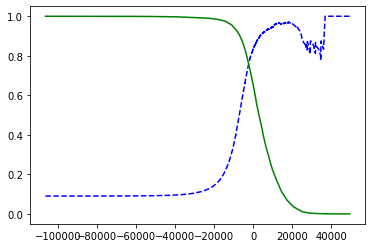

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
# precision increases as threshold increases

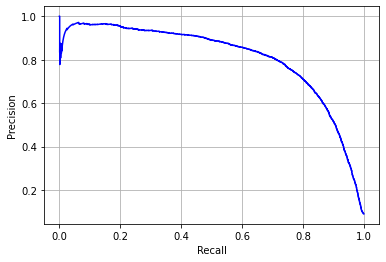

In [64]:
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", label="Precision")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    
plot_precision_recall(precisions, recalls)
# at 90% precision recall is at 50%  as calculated by the details below.

In [47]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # 
print(threshold_90_precision)
y_train_pred_90 = (y_scores >= threshold_90_precision)

3370.0194991439557


In [50]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred_90))
recall_score(y_train_5, y_train_pred_90) # this show recall is less.


0.9000345901072293


0.4799852425751706

In [59]:
#The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers
#the ROC curve plots the true positive rate (another name for recall) against the false positive rate (1 – specificity)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

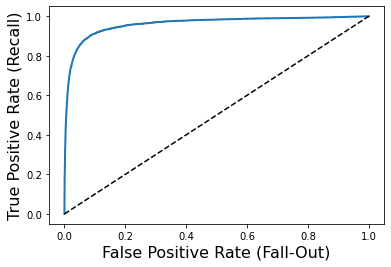

In [66]:
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16) 


plot_roc_curve(fpr, tpr) 
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [71]:
#compare RandomForestClassifier with SGDClassifier.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42) 
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="lower right") 
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Multiclass

In [72]:
#Will take time OVA
sgd_clf.fit(X_train, y_train) # y_train, not y_traiit])

array([3], dtype=uint8)

In [85]:
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

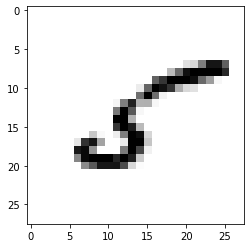

In [84]:

some_digit = X[11]  # y[0] is predicted as 3 use 11
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest") 
plt.axis("on")
plt.show()

In [86]:
#Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores 

array([[-30446.28807622, -20771.5971377 ,  -4069.97324426,
         -7297.18084344,  -2335.35560779,   3839.63697115,
        -27845.48223256, -11660.53889926,   -540.54962964,
        -11918.2854924 ]])

In [34]:
#np.argmax(some_digit_scores)
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [87]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [94]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) 
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") 

array([0.8983, 0.891 , 0.9018])

In [89]:
#RandomForestClassifier
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [91]:
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [92]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.05, 0.02, 0.  , 0.  , 0.9 , 0.  , 0.  , 0.01, 0.01]])

Error Analysis 

In [93]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray) 
plt.show()

NameError: name 'X_train_scaled' is not defined